In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 30 18:39:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   36C    P0    48W / 165W |      0MiB / 24258MiB |     74%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6446461870000348
GPU (s):
0.03159341800346738
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.resnet50.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
94781440/94765736 [==============================] - 79s 1us/step
Using preprocessing
Epoch 1/100
360/360 [==============================] - 20s 42ms/step - loss: 0.9547 - accuracy: 0.6550 - val_loss: 0.6585 - val_accuracy: 0.7259
Epoch 2/100
360/360 [==============================] - 15s 42ms/step - loss: 0.6866 - accuracy: 0.7155 - val_loss: 0.6464 - val_accuracy: 0.7348
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6424 - accuracy: 0.7344 - val_loss: 0.5931 - val_accuracy: 0.7659
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6198 - accuracy: 0.7445 - val_loss: 0.5892 - val_accuracy: 0.7648
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6001 - accuracy: 0.7516 - val_loss: 0.5626 - val_accuracy: 0.7754
Epoch 6/100
360/360 [===================

360/360 [==============================] - 13s 35ms/step - loss: 0.4532 - accuracy: 0.8199 - val_loss: 0.4817 - val_accuracy: 0.8107
Epoch 55/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4536 - accuracy: 0.8194 - val_loss: 0.4665 - val_accuracy: 0.8204
Epoch 56/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4544 - accuracy: 0.8196 - val_loss: 0.4701 - val_accuracy: 0.8121
Epoch 57/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4550 - accuracy: 0.8159 - val_loss: 0.4897 - val_accuracy: 0.8036
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4505 - accuracy: 0.8193 - val_loss: 0.4692 - val_accuracy: 0.8161
Epoch 59/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4504 - accuracy: 0.8187 - val_loss: 0.4845 - val_accuracy: 0.8126
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4504 - accuracy: 0.8211 - val_loss: 0.4723 - val_accuracy

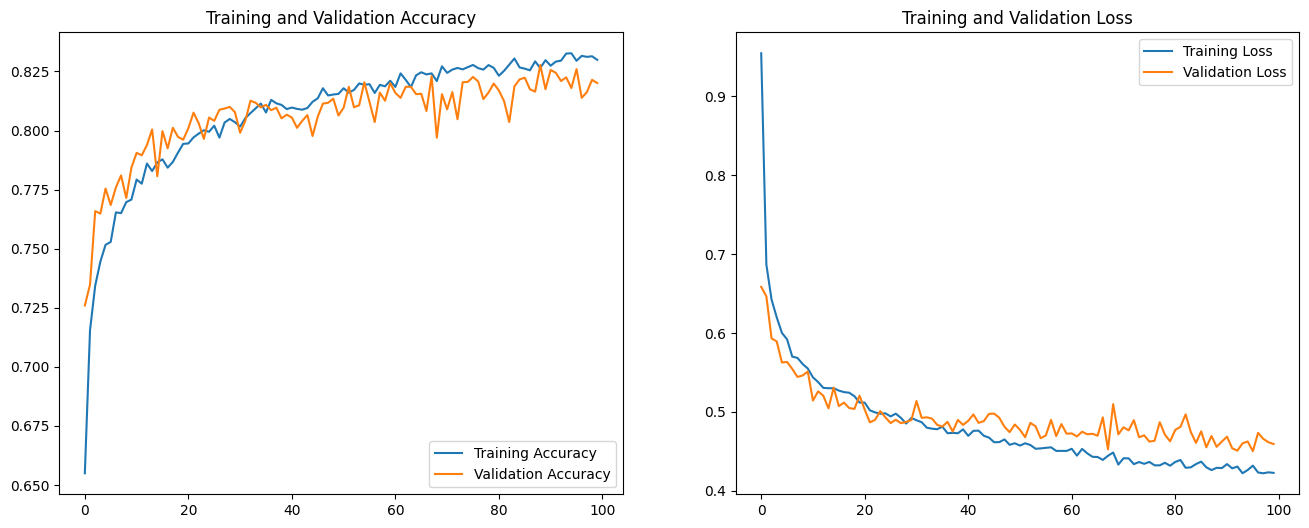

In [5]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 19s 38ms/step - loss: 1.0220 - accuracy: 0.6456 - val_loss: 0.6727 - val_accuracy: 0.7188
Epoch 2/100
360/360 [==============================] - 13s 35ms/step - loss: 0.6945 - accuracy: 0.7098 - val_loss: 0.6395 - val_accuracy: 0.7207
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 0.6609 - accuracy: 0.7237 - val_loss: 0.6164 - val_accuracy: 0.7385
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 0.6364 - accuracy: 0.7353 - val_loss: 0.6672 - val_accuracy: 0.7034
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6181 - accuracy: 0.7423 - val_loss: 0.6037 - val_accuracy: 0.7468
Epoch 6/100
360/360 [==============================] - 13s 35ms/step - loss: 0.6097 - accuracy: 0.7463 - val_loss: 0.5882 - va

360/360 [==============================] - 13s 36ms/step - loss: 0.4786 - accuracy: 0.8063 - val_loss: 0.4978 - val_accuracy: 0.8088
Epoch 57/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4821 - accuracy: 0.8043 - val_loss: 0.5029 - val_accuracy: 0.7984
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4771 - accuracy: 0.8048 - val_loss: 0.4898 - val_accuracy: 0.8104
Epoch 59/100
360/360 [==============================] - 12s 35ms/step - loss: 0.4746 - accuracy: 0.8089 - val_loss: 0.5083 - val_accuracy: 0.7992
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4750 - accuracy: 0.8082 - val_loss: 0.4884 - val_accuracy: 0.8076
Epoch 61/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4715 - accuracy: 0.8111 - val_loss: 0.5006 - val_accuracy: 0.8060
Epoch 62/100
360/360 [==============================] - 12s 35ms/step - loss: 0.4785 - accuracy: 0.8046 - val_loss: 0.4891 - val_accuracy

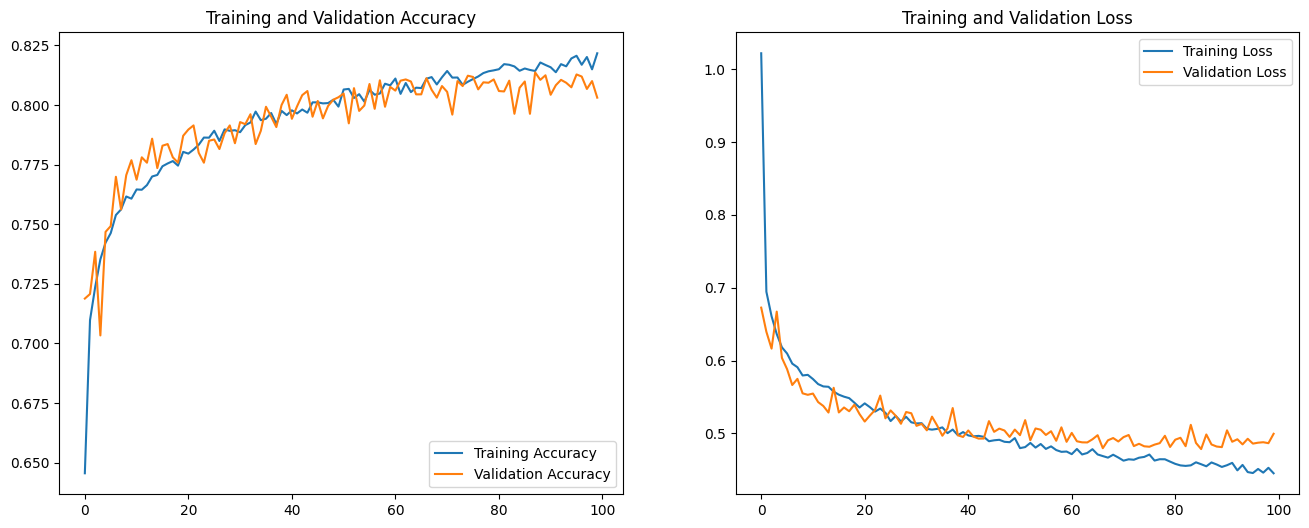

In [6]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 37ms/step - loss: 0.7223 - accuracy: 0.7323 - val_loss: 0.4873 - val_accuracy: 0.8024
Epoch 2/100
360/360 [==============================] - 13s 35ms/step - loss: 0.5018 - accuracy: 0.7944 - val_loss: 0.4831 - val_accuracy: 0.8116
Epoch 3/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4721 - accuracy: 0.8103 - val_loss: 0.4163 - val_accuracy: 0.8378
Epoch 4/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4447 - accuracy: 0.8252 - val_loss: 0.3872 - val_accuracy: 0.8569
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4210 - accuracy: 0.8320 - val_loss: 0.3826 - val_accuracy: 0.8498
Epoch 6/100
360/360 [==============================] - 13s 35ms/step - loss: 0.4201 - accuracy: 0.8327 - v

360/360 [==============================] - 12s 35ms/step - loss: 0.2970 - accuracy: 0.8847 - val_loss: 0.3037 - val_accuracy: 0.8866
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2979 - accuracy: 0.8854 - val_loss: 0.3042 - val_accuracy: 0.8838
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3016 - accuracy: 0.8814 - val_loss: 0.3003 - val_accuracy: 0.8845
Epoch 59/100
360/360 [==============================] - 12s 35ms/step - loss: 0.2920 - accuracy: 0.8864 - val_loss: 0.3115 - val_accuracy: 0.8795
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 0.2943 - accuracy: 0.8827 - val_loss: 0.3149 - val_accuracy: 0.8836
Epoch 61/100
360/360 [==============================] - 12s 35ms/step - loss: 0.2957 - accuracy: 0.8834 - val_loss: 0.2950 - val_accuracy: 0.8932
Epoch 62/100
360/360 [==============================] - 13s 35ms/step - loss: 0.2946 - accuracy: 0.8850 - val_loss: 0.3037 - val_accuracy

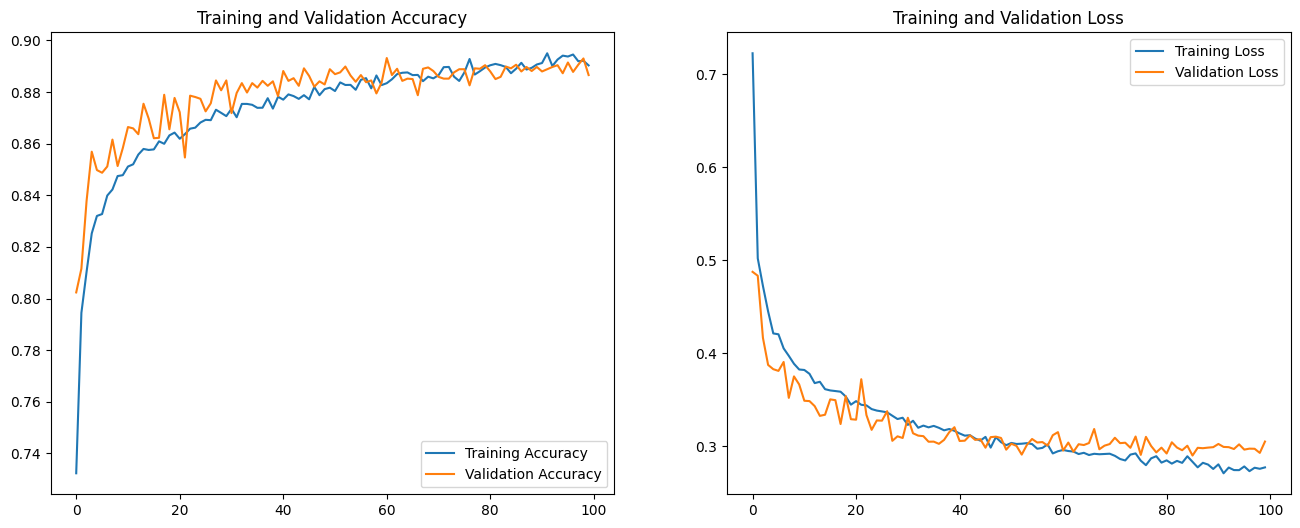

In [7]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 18s 36ms/step - loss: 0.6202 - accuracy: 0.7537 - val_loss: 0.4115 - val_accuracy: 0.8307
Epoch 2/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4691 - accuracy: 0.8119 - val_loss: 0.3924 - val_accuracy: 0.8473
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4368 - accuracy: 0.8226 - val_loss: 0.3791 - val_accuracy: 0.8447
Epoch 4/100
360/360 [==============================] - 12s 35ms/step - loss: 0.4159 - accuracy: 0.8330 - val_loss: 0.3477 - val_accuracy: 0.8666
Epoch 5/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3993 - accuracy: 0.8383 - val_loss: 0.3537 - val_accuracy: 0.8602
Epoch 6/100
360/360 [==============================] - 12s 35ms/step - loss: 0.3820 - accuracy: 0.8500 - val_loss: 0.3372 - va

360/360 [==============================] - 12s 35ms/step - loss: 0.2811 - accuracy: 0.8901 - val_loss: 0.2820 - val_accuracy: 0.8892
Epoch 57/100
360/360 [==============================] - 13s 35ms/step - loss: 0.2858 - accuracy: 0.8877 - val_loss: 0.2795 - val_accuracy: 0.8920
Epoch 58/100
360/360 [==============================] - 12s 35ms/step - loss: 0.2779 - accuracy: 0.8882 - val_loss: 0.2837 - val_accuracy: 0.8937
Epoch 59/100
360/360 [==============================] - 13s 35ms/step - loss: 0.2811 - accuracy: 0.8898 - val_loss: 0.2711 - val_accuracy: 0.8981
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 0.2798 - accuracy: 0.8913 - val_loss: 0.2791 - val_accuracy: 0.8908
Epoch 61/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2844 - accuracy: 0.8886 - val_loss: 0.2737 - val_accuracy: 0.8932
Epoch 62/100
360/360 [==============================] - 13s 35ms/step - loss: 0.2823 - accuracy: 0.8910 - val_loss: 0.2838 - val_accuracy

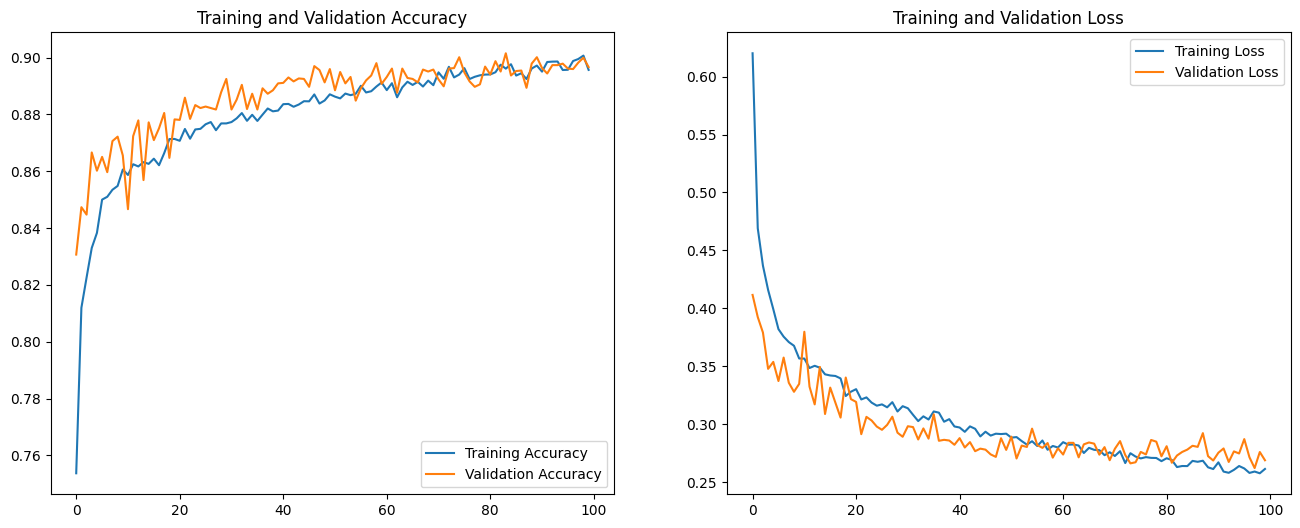

In [8]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 18s 38ms/step - loss: 0.7453 - accuracy: 0.7000 - val_loss: 0.5701 - val_accuracy: 0.7515
Epoch 2/100
360/360 [==============================] - 12s 34ms/step - loss: 0.5823 - accuracy: 0.7526 - val_loss: 0.5141 - val_accuracy: 0.7833
Epoch 3/100
360/360 [==============================] - 12s 35ms/step - loss: 0.5494 - accuracy: 0.7655 - val_loss: 0.4934 - val_accuracy: 0.7944
Epoch 4/100
360/360 [==============================] - 12s 35ms/step - loss: 0.5313 - accuracy: 0.7745 - val_loss: 0.4704 - val_accuracy: 0.8071
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5083 - accuracy: 0.7895 - val_loss: 0.4651 - val_accuracy: 0.8046
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5015 - accuracy: 0.7895 - v

360/360 [==============================] - 13s 35ms/step - loss: 0.3666 - accuracy: 0.8551 - val_loss: 0.3835 - val_accuracy: 0.8487
Epoch 57/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3712 - accuracy: 0.8484 - val_loss: 0.3851 - val_accuracy: 0.8557
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3661 - accuracy: 0.8531 - val_loss: 0.3779 - val_accuracy: 0.8479
Epoch 59/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3659 - accuracy: 0.8534 - val_loss: 0.3792 - val_accuracy: 0.8543
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3664 - accuracy: 0.8543 - val_loss: 0.3960 - val_accuracy: 0.8484
Epoch 61/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3643 - accuracy: 0.8538 - val_loss: 0.3807 - val_accuracy: 0.8479
Epoch 62/100
360/360 [==============================] - 12s 35ms/step - loss: 0.3616 - accuracy: 0.8544 - val_loss: 0.3843 - val_accuracy

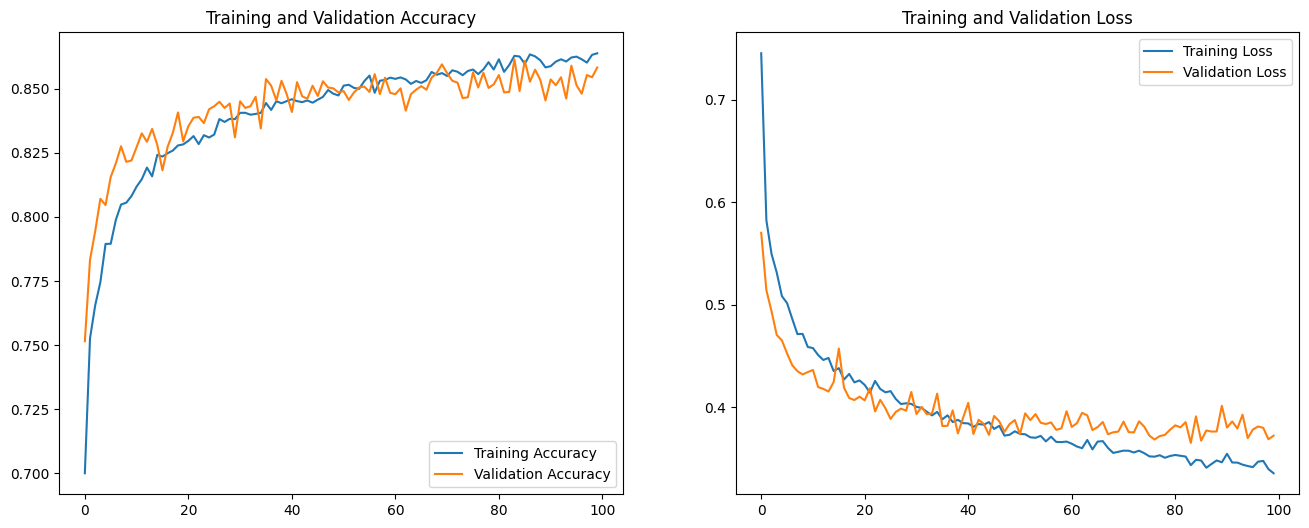

In [9]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 18s 40ms/step - loss: 0.6725 - accuracy: 0.7285 - val_loss: 0.5137 - val_accuracy: 0.7859
Epoch 2/100
360/360 [==============================] - 13s 35ms/step - loss: 0.5320 - accuracy: 0.7755 - val_loss: 0.4426 - val_accuracy: 0.8265
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4995 - accuracy: 0.7941 - val_loss: 0.4278 - val_accuracy: 0.8288
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4726 - accuracy: 0.8046 - val_loss: 0.4130 - val_accuracy: 0.8338
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4563 - accuracy: 0.8134 - val_loss: 0.4058 - val_accuracy: 0.8402
Epoch 6/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4417 - accuracy: 0.8216 - val_loss: 0.3974 - va

360/360 [==============================] - 12s 34ms/step - loss: 0.3316 - accuracy: 0.8680 - val_loss: 0.3321 - val_accuracy: 0.8746
Epoch 57/100
360/360 [==============================] - 12s 35ms/step - loss: 0.3221 - accuracy: 0.8689 - val_loss: 0.3261 - val_accuracy: 0.8725
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3211 - accuracy: 0.8706 - val_loss: 0.3294 - val_accuracy: 0.8725
Epoch 59/100
360/360 [==============================] - 12s 35ms/step - loss: 0.3278 - accuracy: 0.8692 - val_loss: 0.3242 - val_accuracy: 0.8767
Epoch 60/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3286 - accuracy: 0.8695 - val_loss: 0.3325 - val_accuracy: 0.8744
Epoch 61/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3237 - accuracy: 0.8718 - val_loss: 0.3410 - val_accuracy: 0.8654
Epoch 62/100
360/360 [==============================] - 13s 35ms/step - loss: 0.3211 - accuracy: 0.8731 - val_loss: 0.3262 - val_accuracy

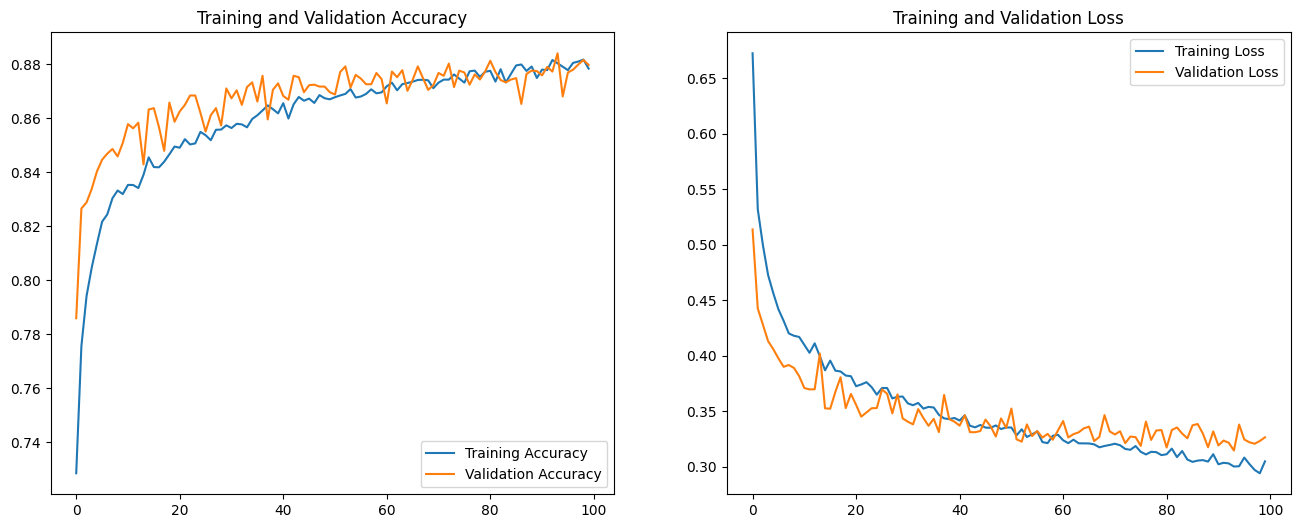

In [10]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [11]:
pd.DataFrame(res_hls_pre).to_csv("resnet50_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("resnet50_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("resnet50_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("resnet50_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("resnet50_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("resnet50_nontrainable/res_ycrcb_nonpre.csv", index=False)